In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow==2.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-server

In [ ]:

import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
import random
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import os

data_path = '/content/drive/My Drive/Minor/DFFDC'
for folder in os.listdir(data_path):
    print(folder, "contains:", os.listdir(os.path.join(data_path, folder))[:5])


Real contains: ['vid102_.mp4', 'vid101_.mp4', 'vid104_.mp4', 'vid100_.mp4', 'vid1000_.mp4']
Fake contains: ['vid100_f.mp4', 'vid117_f.mp4', 'vid139_f.mp4', 'vid132_f.mp4', 'vid12_f.mp4']


In [ ]:
import os

data_path = '/content/drive/My Drive/Minor/DFFDC'
real_path = os.path.join(data_path, 'Real')
fake_path = os.path.join(data_path, 'Fake')

# List videos
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

print(f"Number of real videos: {len(real_videos)}")
print(f"Number of fake videos: {len(fake_videos)}")


Number of real videos: 834
Number of fake videos: 1000


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remounting

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os

# Path to the Fake videos directory
fake_path = '/content/drive/My Drive/Minor/DFFDC/Fake'

# List of all video files in the Fake directory
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

def extract_frames(video_paths, frame_count=1):
    """
    Extract frames from a list of videos.

    Parameters:
        video_paths (list): List of video file paths.
        frame_count (int): Number of frames to extract from each video.

    Returns:
        numpy.ndarray: Array of extracted frames.
    """
    frames = []
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Cannot open video {video_path}")
            continue
        success, frame = cap.read()
        frame_idx = 0
        while success and frame_idx < frame_count:
            # Resize the frame to 224x224
            resized_frame = cv2.resize(frame, (224, 224))
            frames.append(resized_frame)
            success, frame = cap.read()
            frame_idx += 1
        cap.release()
    return np.array(frames)

# Extract frames from fake videos
fake_images_data = extract_frames(fake_videos, frame_count=1)

# Check the results
if fake_images_data.size == 0:
    print("No frames extracted from fake videos.")
else:
    print(f"Shape of extracted fake frames: {fake_images_data.shape}")

# Save extracted frames
output_path = '/content/drive/My Drive/Minor/fake_images_data.npy'
np.save(output_path, fake_images_data)
print(f"Fake frames saved to {output_path}")


Shape of extracted fake frames: (1000, 224, 224, 3)
Fake frames saved to /content/drive/My Drive/Minor/fake_images_data.npy


In [ ]:
import cv2
import numpy as np
import os

# Path to the Real videos directory
real_path = '/content/drive/My Drive/Minor/DFFDC/Real'

# List of all video files in the Real directory
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]

def extract_frames(video_paths, frame_count=1):
    """
    Extract frames from a list of videos.

    Parameters:
        video_paths (list): List of video file paths.
        frame_count (int): Number of frames to extract from each video.

    Returns:
        numpy.ndarray: Array of extracted frames.
    """
    frames = []
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Cannot open video {video_path}")
            continue
        success, frame = cap.read()
        frame_idx = 0
        while success and frame_idx < frame_count:
            # Resize the frame to 224x224
            resized_frame = cv2.resize(frame, (224, 224))
            frames.append(resized_frame)
            success, frame = cap.read()
            frame_idx += 1
        cap.release()
    return np.array(frames)

# Extract frames from real videos
real_images_data = extract_frames(real_videos, frame_count=1)

# Check the results
if real_images_data.size == 0:
    print("No frames extracted from real videos.")
else:
    print(f"Shape of extracted real frames: {real_images_data.shape}")

# Save extracted frames
output_path = '/content/drive/My Drive/Minor/real_images_data.npy'
np.save(output_path, real_images_data)
print(f"Real frames saved to {output_path}")


In [ ]:
# Concatenate both real and fake frames
data = np.concatenate((real_images_data, fake_images_data), axis=0)
print(f"Data shape after concatenation: {data.shape}")

In [ ]:
# Create labels: 0 for real, 1 for fake
real_labels = np.zeros(len(real_images_data))  # Label 0 for real
fake_labels = np.ones(len(fake_images_data))  # Label 1 for fake
labels = np.concatenate((real_labels, fake_labels), axis=0)
print(f"Labels shape: {labels.shape}")


Labels shape: (1834,)


In [ ]:
# Save the data and labels as .npy files
data_output_path = '/content/drive/My Drive/Minor/data_dffdc.npy'
labels_output_path = '/content/drive/My Drive/Minor/label_dffdc.npy'

np.save(data_output_path, data)
np.save(labels_output_path, labels)

In [ ]:
data = np.load ('/content/drive/My Drive/Minor/data_dffdc.npy',mmap_mode='r')
labels = np.load ('/content/drive/My Drive/Minor/label_dffdc.npy',mmap_mode='r')

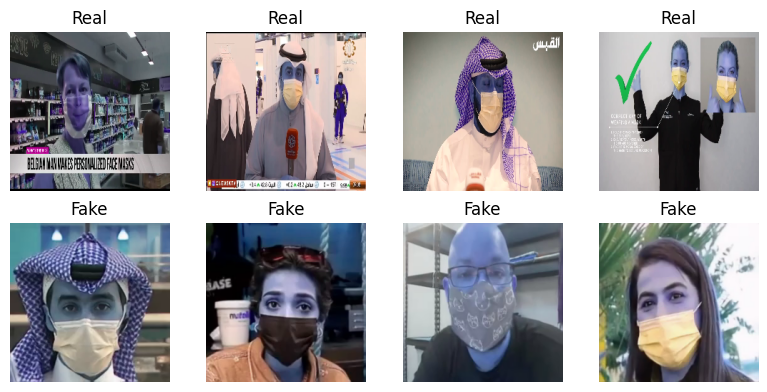

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique class labels in the labels array (e.g., 0 for Fake, 1 for Real)
unique_classes = np.unique(labels)

# Create a dictionary to store four random data samples from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {1: "Fake", 0: "Real"}

# Select four random data samples from each class
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]  # Get indices for each class
    random_indices = np.random.choice(class_indices, 4, replace=False)  # Randomly select 4 indices
    class_samples[class_label] = [data[index] for index in random_indices]

# Plot the randomly selected images in 2 rows and 4 columns
plt.figure(figsize=(8, 4))  # Adjust figure size as needed
for i, (class_label, image_data_list) in enumerate(class_samples.items()):
    class_name = class_names[class_label]  # Get the corresponding class name
    for j, image_data in enumerate(image_data_list):
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(image_data)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()


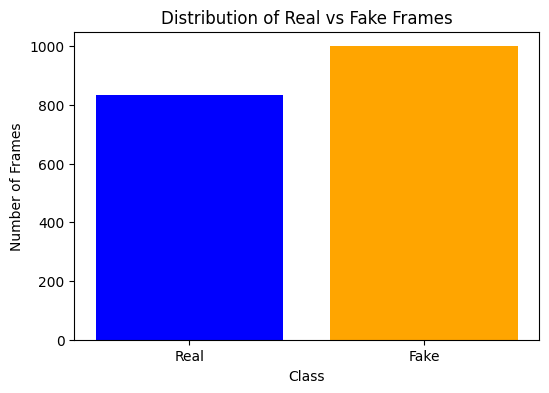

In [ ]:
import matplotlib.pyplot as plt

# Count the number of real and fake labels
real_count = np.sum(labels == 0)  # Count of real (label 0)
fake_count = np.sum(labels == 1)  # Count of fake (label 1)

# Plot the bar graph
plt.figure(figsize=(6, 4))
plt.bar(['Real', 'Fake'], [real_count, fake_count], color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Number of Frames')
plt.title('Distribution of Real vs Fake Frames')
plt.show()


In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify = labels, random_state = 42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, stratify = train_labels, random_state = 42)

In [ ]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (1173, 224, 224, 3)
train_labels shape: (1173,)
val_data shape: (294, 224, 224, 3)
val_labels shape: (294,)
test_data shape: (367, 224, 224, 3)
test_labels shape: (367,)


In [ ]:
from keras.utils import to_categorical

# If labels are integer-encoded, you can convert them to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

print(train_labels.shape)  # Should print (num_samples, 2)


(1173, 2)


In [ ]:
class_names_mapping = { 1: "Fake", 0: "Real" }
# Calculate class distribution in each set
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# Print class distribution mapping
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

Fake
 - Train: 640.0
 - Validation: 160.0
 - Test: 200.0
Real
 - Train: 533.0
 - Validation: 134.0
 - Test: 167.0


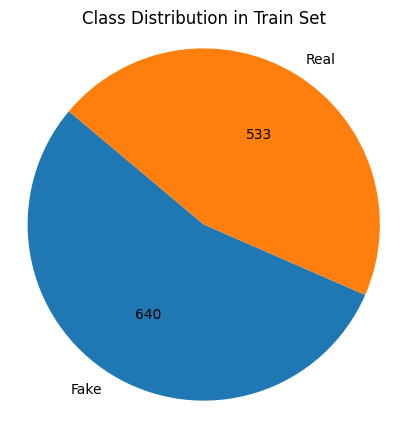

In [ ]:
# Create pie charts for each set
for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

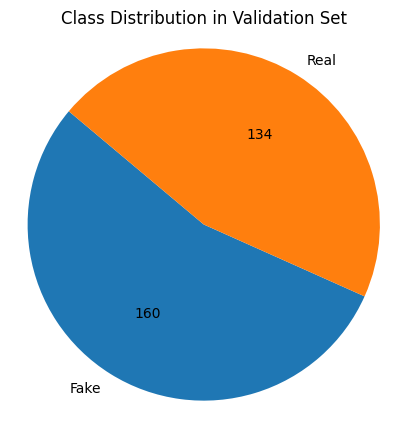

In [ ]:
# Create pie charts for each set
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


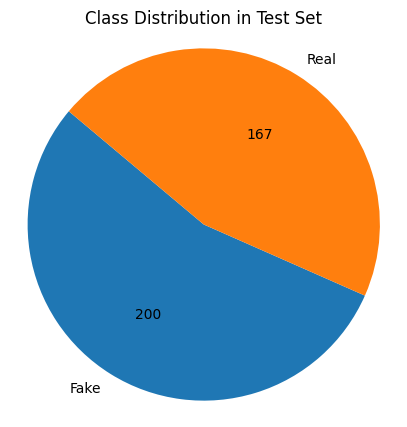

In [ ]:
# Create pie charts for each set
for set_name in ['Test']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [ ]:
# Convert one-hot encoded labels to class labels
train_labels_encoded = np.argmax(train_labels, axis=1)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)

# Create a dictionary of class weights to use in your model training
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 1.100375234521576, 1: 0.91640625}

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
#early_stop = EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
saved_model = ('/content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5')
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)

# callback_list = [early_stop, model_chkpt, lr_reduce]
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = InceptionResNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = BatchNormalization()(x)      # Batch normalization
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout for regularization
predictions = Dense(2, activation='softmax')(x)  # Output layer

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5')

In [ ]:
epochs = 20
batch_size = 64

In [ ]:
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict)

Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.6777  
Epoch 1: val_accuracy improved from -inf to 0.47619, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1395s 72s/step - loss: 0.6482 - accuracy: 0.6777 - val_loss: 6.2839 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.9488  
Epoch 2: val_accuracy improved from 0.47619 to 0.47959, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1403s 74s/step - loss: 0.3394 - accuracy: 0.9488 - val_loss: 2.4173 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9829  
Epoch 3: val_accuracy did not improve from 0.47959
19/19 [==============================] - 1319s 69s/step - loss: 0.1376 - accuracy: 0.9829 - val_loss: 1.8449 - val_accurac

In [ ]:
last_saved_epoch = 3
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict,
                    initial_epoch = last_saved_epoch)

Epoch 4/10
19/19 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9693  
Epoch 4: val_accuracy improved from -inf to 0.48299, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1586s 83s/step - loss: 0.1673 - accuracy: 0.9693 - val_loss: 4.2127 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9898  
Epoch 5: val_accuracy improved from 0.48299 to 0.70068, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1580s 83s/step - loss: 0.0776 - accuracy: 0.9898 - val_loss: 1.3856 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 6/10
19/19 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9915  
Epoch 6: val_accuracy did not improve from 0.70068
19/19 [==============================] - 1562s 82s/step - loss: 0.0474 - accuracy: 0.9915 - val_loss: 3.1756 - val_accurac

In [ ]:
last_saved_epoch = 10
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict,
                    initial_epoch = last_saved_epoch)

Epoch 11/15
19/19 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9949  
Epoch 11: val_accuracy improved from -inf to 0.48980, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1598s 82s/step - loss: 0.0439 - accuracy: 0.9949 - val_loss: 5.1638 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 12/15
19/19 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9957  
Epoch 12: val_accuracy improved from 0.48980 to 0.70068, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1584s 83s/step - loss: 0.0433 - accuracy: 0.9957 - val_loss: 1.7275 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 13/15
19/19 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9974  
Epoch 13: val_accuracy improved from 0.70068 to 0.75850, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 

In [ ]:
last_saved_epoch = 15
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict,
                    initial_epoch = last_saved_epoch)

Epoch 16/20
19/19 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9966  
Epoch 16: val_accuracy improved from 0.90136 to 0.95918, saving model to /content/drive/MyDrive/Minor/InceptionResNet_dffdc.h5
19/19 [==============================] - 1595s 84s/step - loss: 0.0306 - accuracy: 0.9966 - val_loss: 0.1357 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 17/20
19/19 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9932  
Epoch 17: val_accuracy did not improve from 0.95918
19/19 [==============================] - 1523s 80s/step - loss: 0.0357 - accuracy: 0.9932 - val_loss: 1.9969 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 18/20
19/19 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9898  
Epoch 18: val_accuracy did not improve from 0.95918
19/19 [==============================] - 1524s 80s/step - loss: 0.0486 - accuracy: 0.9898 - val_loss: 5.0513 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 19/20
19/19 [========================

Text(0.5, 1.0, 'Training and validation loss')

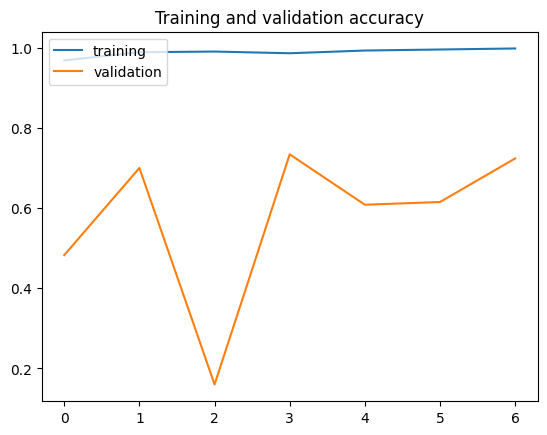

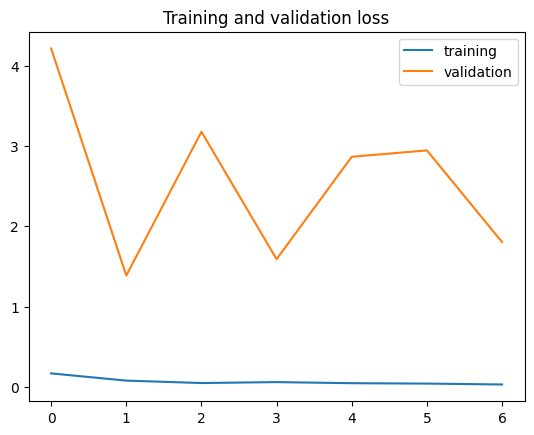

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

Text(0.5, 1.0, 'Training and validation loss')

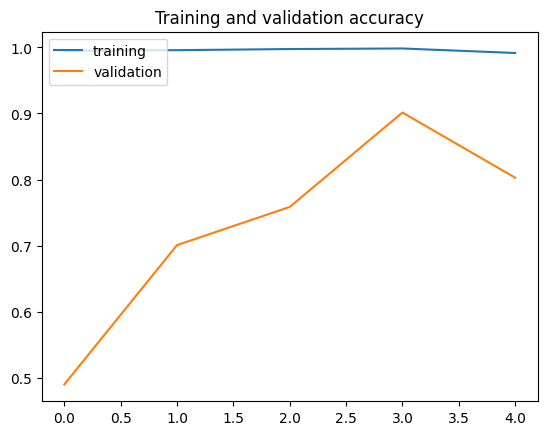

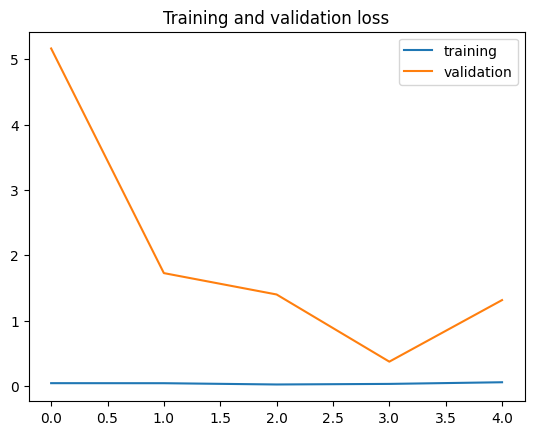

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

Text(0.5, 1.0, 'Training and validation loss')

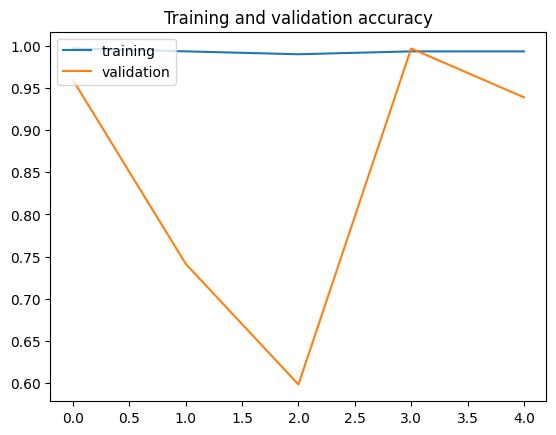

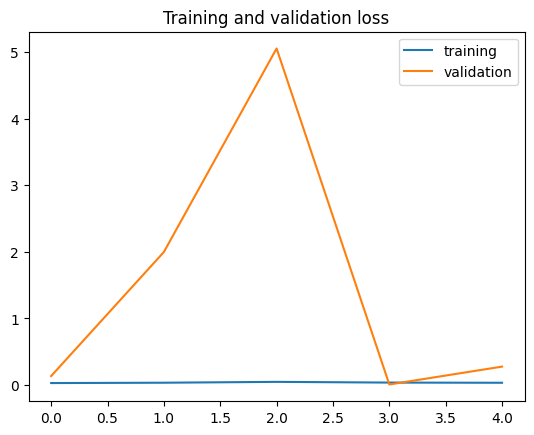

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
print(history.history)


{'loss': [0.1673281341791153, 0.07755794376134872, 0.047432322055101395, 0.05913237854838371, 0.04528554901480675, 0.04053152725100517, 0.029467850923538208], 'accuracy': [0.9693094491958618, 0.9897698163986206, 0.9914748668670654, 0.9872123003005981, 0.9940323829650879, 0.9965899586677551, 0.9991474747657776], 'val_loss': [4.212730407714844, 1.3856028318405151, 3.175621509552002, 1.5896649360656738, 2.864297389984131, 2.943972110748291, 1.8027966022491455], 'val_accuracy': [0.4829931855201721, 0.7006802558898926, 0.15986394882202148, 0.7346938848495483, 0.6088435649871826, 0.615646243095398, 0.7244898080825806], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 102s 9s/step - loss: 0.1146 - accuracy: 0.9673
Test Accuracy: 0.9673024415969849


In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
# test_labels = test_data.classes
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

12/12 [==============================] - 101s 9s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       167
           1       1.00      0.94      0.97       200

    accuracy                           0.97       367
   macro avg       0.97      0.97      0.97       367
weighted avg       0.97      0.97      0.97       367



12/12 [==============================] - 122s 10s/step
Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9330    1.0000    0.9653       167
           1     1.0000    0.9400    0.9691       200

    accuracy                         0.9673       367
   macro avg     0.9665    0.9700    0.9672       367
weighted avg     0.9695    0.9673    0.9674       367


Overall Metrics:
Overall Accuracy: 0.9673
Macro-Averaged Precision: 0.9665
Macro-Averaged Recall: 0.9700
Macro-Averaged F1-Score: 0.9672
Weighted-Averaged Precision: 0.9695
Weighted-Averaged Recall: 0.9673
Weighted-Averaged F1-Score: 0.9674


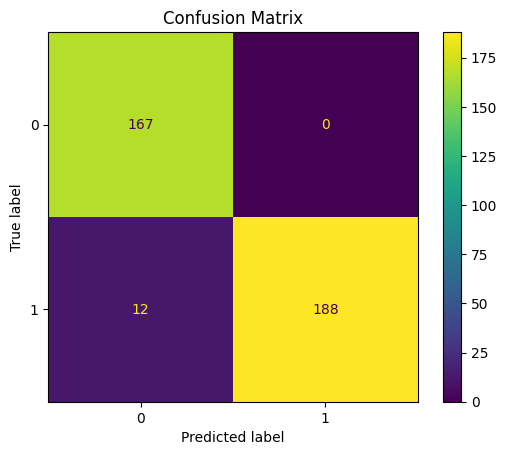

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels, digits=4, output_dict=True)

# Extract overall metrics
overall_accuracy = np.mean(true_labels == predicted_labels)  # Directly calculate overall accuracy
macro_avg = report["macro avg"]
weighted_avg = report["weighted avg"]

# Print the classification report (detailed metrics for each class)
print("Detailed Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))

# Print overall metrics
print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Macro-Averaged Precision: {macro_avg['precision']:.4f}")
print(f"Macro-Averaged Recall: {macro_avg['recall']:.4f}")
print(f"Macro-Averaged F1-Score: {macro_avg['f1-score']:.4f}")
print(f"Weighted-Averaged Precision: {weighted_avg['precision']:.4f}")
print(f"Weighted-Averaged Recall: {weighted_avg['recall']:.4f}")
print(f"Weighted-Averaged F1-Score: {weighted_avg['f1-score']:.4f}")

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(true_labels))
disp.plot(cmap="viridis", colorbar=True)
plt.title("Confusion Matrix")
plt.show()


12/12 [==============================] - 103s 8s/step


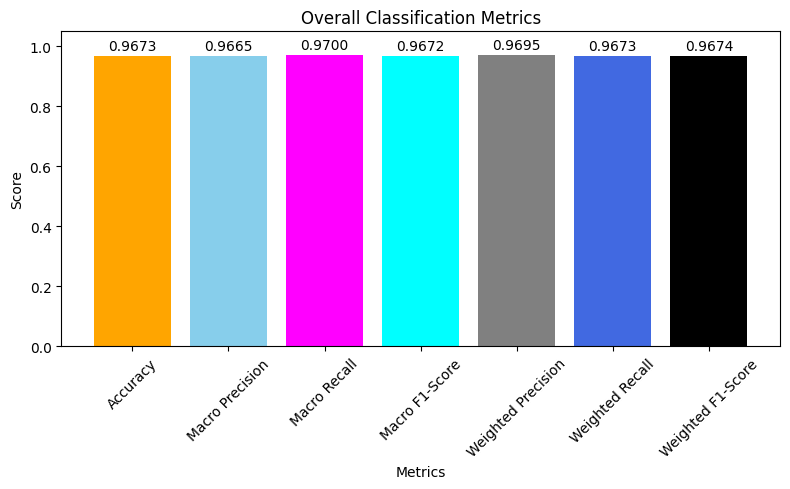

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Example: Generate predictions and true labels
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)

# Extract macro and weighted averages
macro_avg = report["macro avg"]
weighted_avg = report["weighted avg"]

# Metrics to plot
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score",
           "Weighted Precision", "Weighted Recall", "Weighted F1-Score"]
values = [
    overall_accuracy,
    macro_avg["precision"], macro_avg["recall"], macro_avg["f1-score"],
    weighted_avg["precision"], weighted_avg["recall"], weighted_avg["f1-score"]
]

# Plot the bar graph
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))

plt.bar(x, values, color=["orange", "skyblue", "magenta", "cyan", "grey", "royalblue", "black"])

# Add labels, title, and annotations
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Overall Classification Metrics")
plt.xticks(x, metrics, rotation=45)
plt.ylim(0, 1.05)  # Metrics are percentages (0 to 1 range)

# Annotate the bars with their values
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()
